In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import os.path as path
import copy
import matplotlib.pyplot as plt
# from torch.utils.data.sampler import SequentialSampler


from gait_analysis import AnnotationsCasia as Annotations
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
from gait_analysis import Composer

import matplotlib.pyplot as plt

print("done")

done


In [2]:
TIMESTEPS = 40 # size videos


In [3]:
#change configuration in settings.py
c = Config()
c.config['indexing']['grouping'] = 'person_sequence_angle'
c.config['transformers']['DimensionResize']['dimension'] = TIMESTEPS
#c.config['transformers']= {
        #'Transpose' : {'swapping': (2,1,0) , 'target': ["scenes"]},
       # 'Rescale': {'output_size' : (240,320), 'target': ["scenes"]},
        #'AnnotationToLabel': {'target': ["annotations"]},
        #'Transpose' : {'swapping': (1,2,0) , 'target': ["heatmaps"]},
        #'Rescale': {'output_size' : (240,320), 'target': ["heatmaps"]},
        #'DimensionResize' : {'start': 0, 'dimension': 10, 'target': ["heatmaps","annotations"]},
        #'ToTensor': {'target':["heatmaps","annotations"]}
 #   }
composer = Composer()
transformer = composer.compose()
dataset = CasiaDataset(transform=transformer)
print("Desired configuration: heatmaps_1")

loading configuration  heatmaps_1
[OK]
Desired configuration: heatmaps_1


In [4]:
data,_ =dataset[3]

img1 = data["scenes"][3]
poses1 = data["poses"]

print(len(dataset))
print(poses1[3])

745
tensor([[0.9204, 0.5422],
        [0.8879, 0.6618],
        [0.9450, 0.7597],
        [0.8920, 0.5449],
        [0.8675, 0.6754],
        [0.8737, 0.8141],
        [0.8308, 0.8222],
        [0.8390, 0.8357],
        [0.8879, 0.8331],
        [0.9307, 0.8195],
        [0.9368, 0.8167],
        [0.9633, 0.7677]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 320, 3])


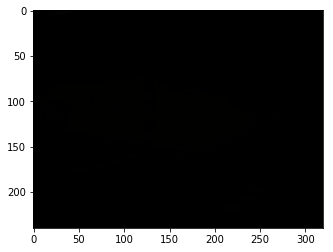

In [5]:
#print(img1)
testimage = img1.int()
testimage = testimage.permute(2,1,0)

#htm_test=htm1[0,:,:,].int()
#htm_test = htm_test.transpose(1,0)
print(testimage.shape)
#print(htm_test.size())

plt.imshow(testimage)

#plt.annotate('25, 50', xy=(poses1[3][0]), xycoords='data',
            # xytext=(0.5, 0.5), textcoords='figure fraction',
            # arrowprops=dict(arrowstyle="->"))
#plt.scatter(25, 50, s=500, c='red', marker='o')
#plt.imshow(htm_test, cmap='jet', alpha=0.2) # interpolation='none'

In [6]:
VALIDATION_SPLIT = 0.2 #indicated ratio of training to validation data: 0.2 -> 20% VALIDATION data
RANDOMIZED_SEED = 20
SHUFFLE_DATASET = False

dataset_size = len(dataset)
indices = list(range(dataset_size))
print("Dataset size:", len(dataset))
print("Indices size:", len(indices))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
print("Split:", split)
if SHUFFLE_DATASET:
    np.random.seed(RANDOMIZED_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
print(len(train_indices))
print(len(test_indices))

BATCH_SIZE_TRAIN = 64 #until now just batch_size = 1
BATCH_SIZE_TEST = 64 #until now just batch_size = 1


train_sampler = torch.utils.data.RandomSampler(train_indices)
test_sampler = torch.utils.data.RandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE_TRAIN, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE_TEST, sampler=test_sampler)

Dataset size: 745
Indices size: 745
Split: 149
596
149


In [7]:
#DESIGN PARAMETERS FOR NEURAL NETWORK
NR_LSTM_UNITS = 1 
#htm = data["heatmaps"][0]


#LSTM_IO_SIZE = htm.size(0) * htm.size(1) * htm.size(2) 
LSTM_IO_SIZE = 24 



LSTM_HIDDEN_SIZE = 2400


#RGB_CHANNELS = 3


SLICE_FROM_TIMESTEP = 0 #slices from timestep SLICE_FROM_TIMESTEP to the last one

OUTPUT_SIZE = TIMESTEPS - SLICE_FROM_TIMESTEP

NR_EPOCHS = 20

learning_rate = 0.0002 # reduce factos of 10 .. some epoch later.
momentum = 0.9
print("Hyperparameters defined")

Hyperparameters defined


In [8]:
for i, batch in enumerate(train_loader):
        inputs, labels = batch
        break

In [9]:
test = torch.stack(inputs["poses"])
print(test.size())

torch.Size([40, 64, 12, 2])


In [10]:
a = torch.Tensor([[0,1,2],[3,4,5],[6,7,8]])
a.unsqueeze_(-1)
a = a.expand(3,3,10)
a = a.contiguous()
#print(a)
a = a.view(3,30)
#print(a)

#print(a[1,:])

In [11]:
class HTM_LSTM(nn.Module):
    def __init__(self):
        super(HTM_LSTM, self).__init__()
        self.avialable_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.lstm1 = nn.LSTM(LSTM_IO_SIZE,
                            LSTM_HIDDEN_SIZE)# horizontal direction
        
        self.lstm2 = nn.LSTM(LSTM_HIDDEN_SIZE,
                            LSTM_HIDDEN_SIZE)# horizontal direction
#         self.lstm2 = nn.LSTM(LSTM_IO_SIZE,
#                             LSTM_HIDDEN_SIZE,
#                             TIMESTEPS)# horizontal direction
        #self.fc1 = nn.Linear(LSTM_HIDDEN_SIZE * OUTPUT_SIZE,10000)
        self.fc1 = nn.Linear(OUTPUT_SIZE * 24,2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024,512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512,256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256,3*OUTPUT_SIZE)
        
        self.dropout = nn.Dropout(p=0.5)
        
        #initialize hidden states of LSTM
        #self.hidden = self.init_hidden()

        #print("Hidden:", _hidden)
    #def init_hidden(self):
    #   return (torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device), 
    #          torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device))
    def forward(self,x):

        x_arr = torch.stack(x)

        #print(x_arr[:,0,:,:])
        #x1, hidden = self.lstm1(x_arr.view(x_arr.size(0),x_arr.size(1),-1))
        #x1, hidden = self.lstm2(x1)
        #x1 = x1.view(x_arr.size(0),x_arr.size(1),LSTM_HIDDEN_SIZE) #output.view(seq_len, batch, num_dir*hidden_size)
        #print('-----------------')
        #print(x1.size())
        #x1 = x1[SLICE_FROM_TIMESTEP:TIMESTEPS,:,:]
        x1 = x_arr[SLICE_FROM_TIMESTEP:TIMESTEPS,:,:]
        
        x1 = x1.permute(1,0,2,3)
        #print(x1.size())
        x1 = x1.contiguous()
        #print(x1.size())
        x1 = x1.view(x1.size(0),-1)
        #print(x1.size())
        #         x = torch.squeeze(x)
        x1 = self.dropout(F.selu(self.bn1(self.fc1(x1))))
        x1 = self.dropout(F.selu(self.bn2(self.fc2(x1))))
        x1 = self.dropout(F.selu(self.bn3(self.fc3(x1))))
        x1 = self.dropout(F.selu(self.bn4(self.fc4(x1))))
        x1 = self.fc5(x1) 
        
        #print(x1.size())
        x1 = x1.view(x1.size(0),3,OUTPUT_SIZE)
        #print(x1.size())
        #print('-----------------')
        #print ("Size network output", x1.shape)
        return x1
print("Class defined")

Class defined


In [12]:
#TRAINING
test_net = HTM_LSTM()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
test_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(test_net.parameters(), lr=learning_rate)

cuda:0


In [13]:
#PREPARATION FOR TRAINING
loss_array = []
learning_rate_array = []

print('Start training...')
print("Expected loss with {} different classes and {} data elements: {}".format(3, len(dataset)-split, (len(dataset)-split)*np.log(3)))
running_loss = 0.0
#print("Data set length:", len((train_loader)), "Validation length:", len(test_loader))
print("Batch size:", BATCH_SIZE_TRAIN)
print("Evaluating first element...")
start_time = time.time()
i, batch = next(iter(enumerate(train_loader)))
inputs, labels = batch
data_in = [s.to(device) for s in inputs['poses']]
labels = labels.to(device)
print("Time steps:{}, input sequence length:{}".format(TIMESTEPS,len(data_in)))
#print("NN input: ",len(flows),len(flows[0]),len(flows[0][0]),len(flows[0][0][0]),len(flows[0][0][0][0]))
optimizer.zero_grad() 
outputs = test_net(data_in)
print("Expected output format: [BATCH, NR_CLASSES, TIMESTEPS]")
print("Output format:", len(outputs), outputs.size())
print("Expected label format: [BATCH, TIMESTEPS] (with int-label each element indicating the correct one)")
print("Labels:", len(labels), labels.size())
print("Slicing loss. Using loss from:",SLICE_FROM_TIMESTEP,"to",TIMESTEPS)
#print("Labels content:", labels)
#original: loss = criterion(outputs.float(),labels.long())
loss = criterion(outputs.float(),labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
loss.backward() 
optimizer.step()

running_loss += loss.data.item()
elapsed_time = time.time() - start_time;
loss_array.append(running_loss)
learning_rate_array.append(learning_rate)
print("Loss:{}, expected loss:{}".format(running_loss, np.log(3)))
print("Time needed:{}s".format(elapsed_time))
print("Expected loss for total training data: ", (len(dataset)-split)*np.log(3))
print("Expected training time per epoch:{} min".format(elapsed_time* len(train_loader)/60))
print("Estimated total training time:{} hours".format(elapsed_time* len(train_loader)*NR_EPOCHS/3600))

Start training...
Expected loss with 3 different classes and 596 data elements: 654.7729240461935
Batch size: 64
Evaluating first element...
Time steps:40, input sequence length:40
Expected output format: [BATCH, NR_CLASSES, TIMESTEPS]
Output format: 64 torch.Size([64, 3, 40])
Expected label format: [BATCH, TIMESTEPS] (with int-label each element indicating the correct one)
Labels: 64 torch.Size([64, 40])
Slicing loss. Using loss from: 0 to 40
Loss:1.182833194732666, expected loss:1.0986122886681098
Time needed:30.60592770576477s
Expected loss for total training data:  654.7729240461935
Expected training time per epoch:5.100987950960795 min
Estimated total training time:1.7003293169869318 hours


Epoch: 0
Loss epoch 0: 0.29197110805735493, took 357.08432126045227s
Accuracy epoch 0: 0.8859479865771812
Accuracytest set: 0.9055369127516778
Epoch: 1
Loss epoch 1: 0.2793376145746884, took 354.98230934143066s
Accuracy epoch 1: 0.8940855704697986
Accuracytest set: 0.8493288590604027
Epoch: 2
Loss epoch 2: 0.2818819385446958, took 367.25947666168213s
Accuracy epoch 2: 0.8916107382550336
Accuracytest set: 0.7308724832214765
Epoch: 3
Loss epoch 3: 0.27268858663987794, took 354.5110192298889s
Accuracy epoch 3: 0.8956795302013423
Accuracytest set: 0.7315436241610738
Epoch: 4
Loss epoch 4: 0.26812165865562104, took 355.1370298862457s
Accuracy epoch 4: 0.8941275167785234
Accuracytest set: 0.7944630872483222
Epoch: 5
Loss epoch 5: 0.28208883176713984, took 358.8729190826416s
Accuracy epoch 5: 0.8893456375838926
Accuracytest set: 0.7451342281879194
Epoch: 6
Loss epoch 6: 0.27968981802063503, took 366.6542570590973s
Accuracy epoch 6: 0.8878775167785234
Accuracytest set: 0.8491610738255033
Epoch

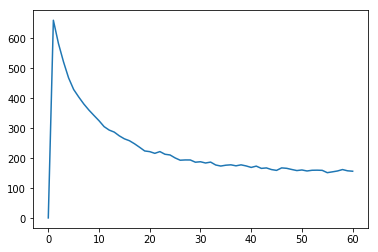

In [16]:
for epoch in range(NR_EPOCHS): 
    running_loss = 0.0
    running_corrects = 0.0
    start_time = time.time()
    print("Epoch:", epoch)
    running_loss = 0.0
    test_net.train()
    
    for i, batch in enumerate(train_loader):
        
        inputs, labels = batch
        data_in = [s.to(device) for s in inputs['poses']]
        labels = labels.to(device)
        
        #print(labels)
        
        optimizer.zero_grad() 
        
        outputs = test_net(data_in)
        #print(outputs.size())

       
        _, preds = torch.max(outputs, 1)
        
        #print(outputs[0,:,SLICE_FROM_TIMESTEP:TIMESTEPS])
       
        
        #print(outputs.size(),'...',labels.size())
        loss = criterion(outputs[0:labels.size(0),:,:].float(),labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
        loss.backward() 
        optimizer.step()
        
        running_loss += loss.data.item()*(data_in[0].size(0))
        running_corrects += torch.sum(preds.long() == labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
       
        #print(running_corrects)
        #print(preds.long())

        #print(labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
        #print(test_net.fc3.weight.data.size())
        #print(test_net.fc3.weight.grad)
        
    
    
    test_net.eval()
    test_corrects = 0.0
    
    for i, batch in enumerate(test_loader):

        inputs, labels = batch
        data_in = [s.to(device) for s in inputs['poses']]
        labels = labels.to(device)
        
        outputs = test_net(data_in)
       
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs[0:labels.size(0),:,:].float(),labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
        
        test_corrects += torch.sum(preds.long() == labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
       
    
    epoch_loss = running_loss / len(train_indices)
    epoch_acc = running_corrects.double() / (len(train_indices)*(TIMESTEPS - SLICE_FROM_TIMESTEP))
    print("Loss epoch {}: {}, took {}s".format(epoch, epoch_loss,time.time()-start_time))
    print("Accuracy epoch {}: {}".format(epoch, epoch_acc))
    test_accuracy = test_corrects.double() / (len(test_indices)*(TIMESTEPS - SLICE_FROM_TIMESTEP))
    print("Accuracytest set: {}".format(test_accuracy))
    loss_array.append(running_loss)
    learning_rate_array.append(learning_rate)

#test_all_preds(test_net) 
print('...Training finished')
plt.plot(loss_array)

In [ ]:
#torch.save(test_net.state_dict(), '/home/ron/PycharmProjects/Gait2019/trained_models/test.pth')

In [ ]:
test = test_net.fc3.weight.grad
test = test.cpu()
plt.imshow(test.float())

In [ ]:
image_list_ch_0 = []
image_list_ch_1 = []ch_2 = []
for a,data in enumerate
image_list_(dataset):
    print(a)
Epoch: 8
Type Markdown and LaTeX:  α2 

​

test = test_net.fc3.weight.grad
test = test.cpu()
test = test_net.fc3.weight.grad
test = test.cpu()
plt.imshow(test.float())

ch_2 = []
for a,data in enumerate
image_list_ch_0 = []
image_list_ch_1 = []ch_2 = []
for a,data in enumerate
image_list_(dataset):
    print(a)
    for image in data[0]['poses']:        
        image_list_ch_0.append(image[0].numpy())
        #image_list_ch_1.append(image[1].numpy())
        #image_list_ch_2.append(image[2].numpy())
print("List of channels created")
mean = [np.mean(image_list_ch_0)]
std_dev = np.sqrt([np.var(image_list_ch_0)])

print(mean)
    for image in data[0]['poses']:        
        image_list_ch_0.append(image[0].numpy())
        #image_list_ch_1.append(image[1].numpy())
        #image_list_ch_2.append(image[2].numpy())
print("List of channels created")
mean = [np.mean(image_list_ch_0)]
std_dev = np.sqrt([np.var(image_list_ch_0)])

In [ ]:
print(mean)

In [ ]:
print(std_dev)